In [1]:
import numpy as np
import pandas as pd
import joblib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [4]:
train_df = pd.read_csv('./data/fl_2022_LastName_train.csv.gz')
val_df = pd.read_csv('./data/fl_2022_LastName_val.csv.gz')
test_df = pd.read_csv('./data/fl_2022_LastName_test.csv.gz')

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1079199, 4)
(134900, 4)
(134900, 4)


In [12]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

## Extract features

In [6]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False)

In [13]:
X_train = vectorizer.fit_transform(train_df['name_last'])
X_val = vectorizer.transform(val_df['name_last'])
X_test = vectorizer.transform(test_df['name_last'])

In [14]:
X_train.shape

(1079191, 1588)

In [15]:
X_val.shape

(134896, 1588)

In [16]:
X_test.shape

(134898, 1588)

In [17]:
vectorizer.get_feature_names_out()

array([' ', " '", ' -', ..., 'zx', 'zy', 'zz'], dtype=object)

In [18]:
len(vectorizer.get_feature_names_out())

1588

In [19]:
vocab = vectorizer.get_feature_names_out()

In [20]:
y_train = train_df.race_code
y_val = val_df.race_code
y_test = test_df.race_code

In [21]:
y_train[0]

3

In [22]:
#Create a Gaussian Classifier
clf = GradientBoostingClassifier(random_state=42, verbose=6)

In [23]:
print(X_train.shape)
print(X_test.shape)

(1079191, 1588)
(134898, 1588)


## Training

## Doing it for 1 million with 100 iterations

In [24]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)

# 1 million
samples = 100 * 100 * 100
# 1 million records took 1h 11min 16s

clf.fit(X_train[:samples], y_train[:samples])

      Iter       Train Loss   Remaining Time 
         1           1.3002           55.32m
         2           1.2699           54.93m
         3           1.2460           53.71m
         4           1.2267           52.77m
         5           1.2111           52.28m
         6           1.1986           51.72m
         7           1.1879           50.64m
         8           1.1786           49.75m
         9           1.1711           49.19m
        10           1.1645           48.46m
        11           1.1588           48.03m
        12           1.1534           47.37m
        13           1.1487           46.82m
        14           1.1447           46.20m
        15           1.1412           45.66m
        16           1.1379           45.15m
        17           1.1347           44.77m
        18           1.1316           44.29m
        19           1.1291           43.76m
        20           1.1267           43.11m
        21           1.1245           42.47m
        2

GradientBoostingClassifier(random_state=42, verbose=6)

In [25]:
%%time
y_pred = clf.predict(X_val)
# Model Accuracy, how often is the classifier correct?
print("Val Accuracy:", metrics.accuracy_score(y_val, y_pred))

Val Accuracy: 0.6178315146483216
CPU times: user 1.72 s, sys: 93 ms, total: 1.81 s
Wall time: 2.16 s


In [26]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.617303444083678
CPU times: user 1.46 s, sys: 64.7 ms, total: 1.52 s
Wall time: 1.71 s


In [27]:
joblib.dump(vectorizer, "models/gb_vec_lastname_1M.joblib", compress=3)  # compression is ON!

['models/gb_vec_lastname_1M.joblib']

In [28]:
joblib.dump(clf, "models/gb_model_lastname_1M.joblib", compress=3)  # compression is ON!

['models/gb_model_lastname_1M.joblib']

## Doing it for 2 million with 100 iterations

In [29]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)
clf = GradientBoostingClassifier(random_state=42, verbose=6)

# 2 million
samples = 2 * 100 * 100 * 100
# 1 million records took 2h 10min 13s
# 2 million records took 3h 50 mins
# 8 million records will take ~17 hours

clf.fit(X_train[:samples], y_train[:samples])

      Iter       Train Loss   Remaining Time 
         1           1.3000           62.70m
         2           1.2697           59.99m
         3           1.2458           59.52m
         4           1.2265           58.41m
         5           1.2109           57.59m
         6           1.1984           56.85m
         7           1.1877           56.37m
         8           1.1784           55.36m
         9           1.1709           54.42m
        10           1.1643           53.80m
        11           1.1586           53.14m
        12           1.1532           52.78m
        13           1.1485           52.32m
        14           1.1445           52.03m
        15           1.1410           51.33m
        16           1.1375           50.60m
        17           1.1345           49.87m
        18           1.1314           49.11m
        19           1.1289           48.31m
        20           1.1264           47.48m
        21           1.1241           46.68m
        2

GradientBoostingClassifier(random_state=42, verbose=6)

In [30]:
%%time
y_pred = clf.predict(X_val)
# Model Accuracy, how often is the classifier correct?
print("Val Accuracy:", metrics.accuracy_score(y_val, y_pred))

Val Accuracy: 0.6179352983038785
CPU times: user 1.8 s, sys: 334 ms, total: 2.13 s
Wall time: 2.31 s


In [31]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.6173479221337603
CPU times: user 1.69 s, sys: 76.5 ms, total: 1.77 s
Wall time: 1.96 s


In [32]:
joblib.dump(vectorizer, "models/gb_vec_lastname_2M.joblib", compress=3)  # compression is ON!

['models/gb_vec_lastname_2M.joblib']

In [33]:
joblib.dump(clf, "models/gb_model_lastname_2M.joblib", compress=3)  # compression is ON!

['models/gb_model_lastname_2M.joblib']

# Now lets do for the whole train dataset with 20 iterations

In [34]:
%%time

clf = GradientBoostingClassifier(n_estimators=20, random_state=42, verbose=6)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3000           12.11m
         2           1.2697           11.02m
         3           1.2458           10.36m
         4           1.2265            9.80m
         5           1.2109            9.07m
         6           1.1984            8.36m
         7           1.1877            7.71m
         8           1.1784            7.07m
         9           1.1709            6.46m
        10           1.1643            5.83m
        11           1.1586            5.23m
        12           1.1532            4.64m
        13           1.1485            4.05m
        14           1.1445            3.46m
        15           1.1410            2.88m
        16           1.1375            2.30m
        17           1.1345            1.74m
        18           1.1314            1.17m
        19           1.1289           34.89s
        20           1.1264            0.00s
CPU times: user 11min 7s, sys: 33.6 s, total: 11min 41

GradientBoostingClassifier(n_estimators=20, random_state=42, verbose=6)

In [35]:
%%time
y_pred = clf.predict(X_val)
# Model Accuracy, how often is the classifier correct?
print("Val Accuracy:", metrics.accuracy_score(y_val, y_pred))

Val Accuracy: 0.5985499940695054
CPU times: user 620 ms, sys: 85.6 ms, total: 705 ms
Wall time: 870 ms


In [36]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.5973402126050794
CPU times: user 606 ms, sys: 46.7 ms, total: 653 ms
Wall time: 862 ms


In [37]:
joblib.dump(vectorizer, "models/gb_vec_lastname.joblib", compress=3)  # compression is ON!

['models/gb_vec_lastname.joblib']

In [38]:
joblib.dump(clf, "models/gb_model_lastname.joblib", compress=3)  # compression is ON!

['models/gb_model_lastname.joblib']

## Confusion Matrix

In [39]:
race_id_df = train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)

In [40]:
race_to_id

{'other': 0, 'nh_black': 1, 'nh_white': 2, 'hispanic': 3, 'asian': 4}

In [41]:
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [42]:
id_to_race

{0: 'other', 1: 'nh_black', 2: 'nh_white', 3: 'hispanic', 4: 'asian'}

### For 1M model

In [43]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


              precision    recall  f1-score   support

       asian       0.54      0.03      0.05      6867
    hispanic       0.78      0.67      0.72     38961
    nh_black       0.62      0.08      0.15     13726
    nh_white       0.56      0.92      0.70     60970
       other       0.35      0.00      0.00     14374

    accuracy                           0.62    134898
   macro avg       0.57      0.34      0.32    134898
weighted avg       0.61      0.62      0.54    134898



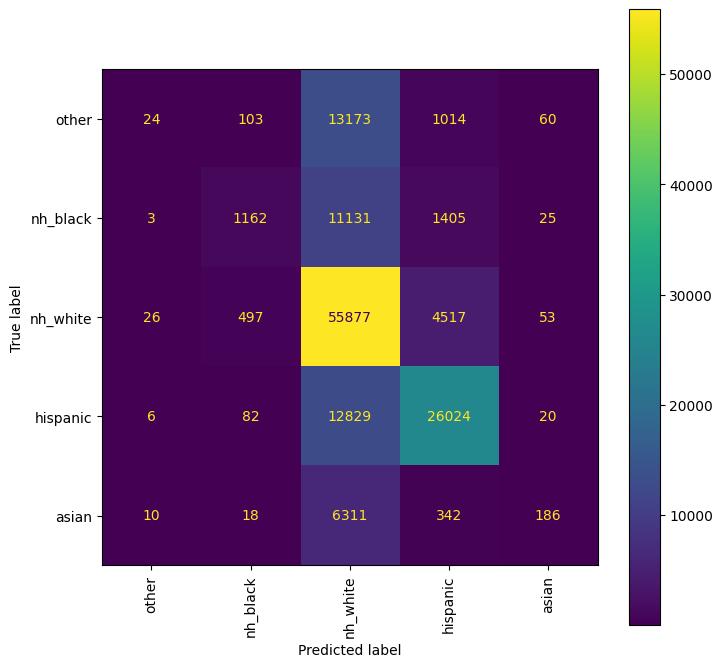

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline  

model_1m = joblib.load('models/gb_model_lastname_1M.joblib')
preds = model_1m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

### For 2M Model

              precision    recall  f1-score   support

       asian       0.53      0.03      0.05      6867
    hispanic       0.78      0.67      0.72     38961
    nh_black       0.63      0.08      0.15     13726
    nh_white       0.56      0.92      0.70     60970
       other       0.38      0.00      0.00     14374

    accuracy                           0.62    134898
   macro avg       0.58      0.34      0.32    134898
weighted avg       0.61      0.62      0.54    134898



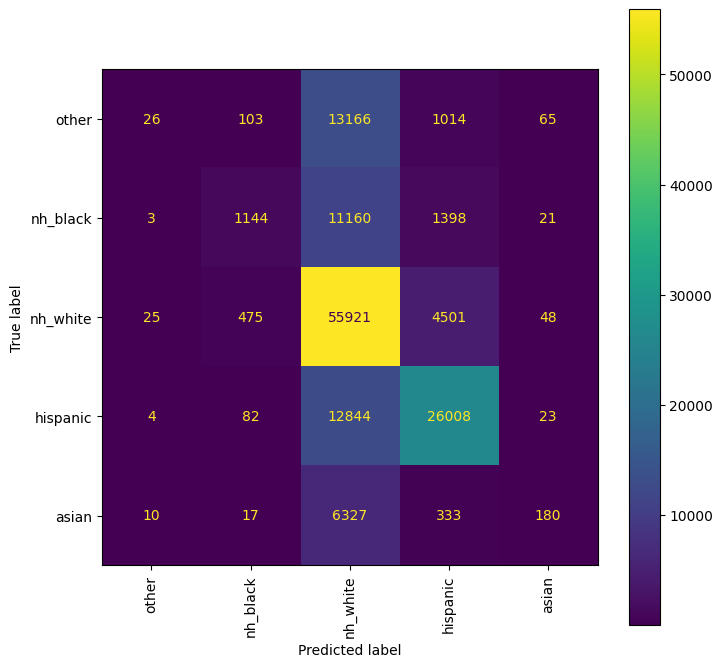

In [46]:
model_2m = joblib.load('models/gb_model_lastname_2M.joblib')
preds = model_2m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

### For Model trained  with complete dataset (20 iterations)

/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       asian       0.61      0.00      0.00      6867
    hispanic       0.73      0.65      0.69     38961
    nh_black       0.62      0.02      0.04     13726
    nh_white       0.55      0.90      0.69     60970
       other       0.00      0.00      0.00     14374

    accuracy                           0.60    134898
   macro avg       0.50      0.31      0.28    134898
weighted avg       0.55      0.60      0.51    134898



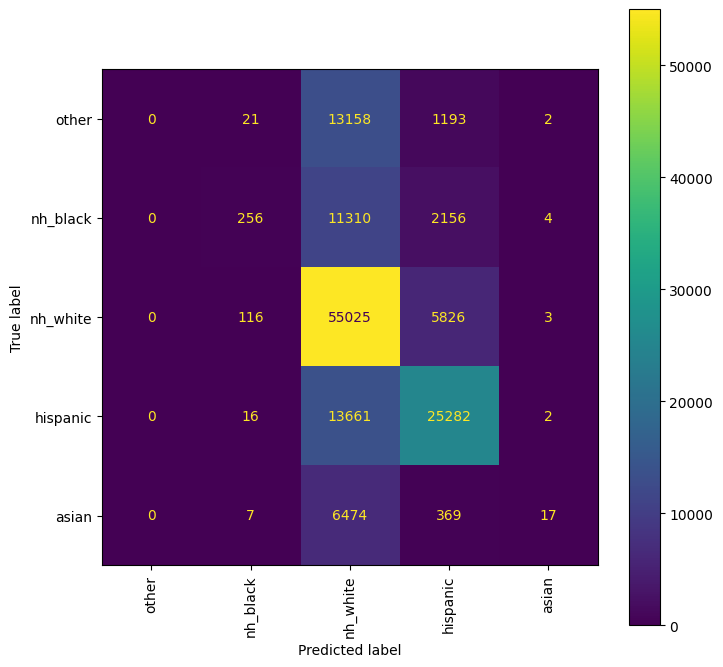

In [47]:
model_full = joblib.load('models/gb_model_lastname.joblib')
preds = model_full.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')